In [55]:
import bottleneck as bn
import dask
import folium
import holoviews as hv
import hvplot.xarray
import matplotlib.pyplot as plt
import numpy as np
import pystac_client
import xarray as xr
import yaml
import zarr

from ascat.read_native.ragged_array_ts import CellFileCollection
from collections import defaultdict
from odc import stac as odc_stac
from pathlib import Path
from pyproj import Transformer
from scipy.spatial import cKDTree
import warnings

dask.config.set(**{"array.slicing.split_large_chunks": True})
hv.extension("bokeh")

with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    # h121_ds = h121_ds.set_index(time="time")

### Loading Sentinel - 1 Sigma Naught Data from EODC STAC Catalogue

In [56]:
eodc_catalog = pystac_client.Client.open("https://stac.eodc.eu/api/v1")

collection_id = "SENTINEL1_SIG0_20M"

collection = eodc_catalog.get_collection(collection_id)

Setting time and area of interest.

In [243]:
time_range ="2022-01-06/2022-01-07" # "2021-01-01/2023-12-31"

latmin, latmax = 44, 45 #30.0, 45.0            # South to North
lonmin, lonmax = 7, 8  #-10.0, 5.0            # West to East

bounding_box = [lonmin, latmin, lonmax, latmax]

Loading the metadata with STAC search engine.

In [244]:
search = eodc_catalog.search(
    collections=collection_id,
    bbox=bounding_box,
    datetime=time_range,
    # max_items=1  # number of max items to load
)
items_eodc = search.item_collection()
print(f"On EODC we found {len(items_eodc)} items for the given search query")

On EODC we found 12 items for the given search query


This data is stored in the Equi7 grid. But our area of interest is in both the european Equi7 grid and the african Equi7 grid. 

Azimuthal Equidistant
- Center latitude: 53        -> Europa
- Center longitude: 24

Azimuthal Equidistant
- Center latitude: 8.5       -> Afrika
- Center longitude: 21.5

We will create two zar files for the different grids that can be fused later.

In [245]:
items_crs_europe = []
items_crs_africa = []
wkt_europe = None
wkt_africa = None

for item in items_eodc:
    wkt = item.properties["proj:wkt2"]
    lat_center = float(wkt.split('PARAMETER["latitude_of_center",')[1].split(']')[0])

    if lat_center == 53.0:
        items_crs_europe.append(item)
        wkt_europe = wkt
    elif lat_center == 8.5:
        items_crs_africa.append(item)
        wkt_africa = wkt

print(f"Equi7 Europe (lat 53.0): {len(items_crs_europe)} items")
print(wkt_europe, "\n")
print(f"Equi7 Africa (lat 8.5): {len(items_crs_africa)} items")
print(wkt_africa)

Equi7 Europe (lat 53.0): 12 items
PROJCS["Azimuthal_Equidistant",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["latitude_of_center",53],PARAMETER["longitude_of_center",24],PARAMETER["false_easting",5837287.81977],PARAMETER["false_northing",2121415.69617],UNIT["metre",1,AUTHORITY["EPSG","9001"]]] 

Equi7 Africa (lat 8.5): 0 items
None


Let's plot thumbnail of the loaded items for this area and those dates.

In [246]:
# better dont run this

#"""
map = folium.Map(
    location=[(latmin + latmax) / 2, (lonmin + lonmax) / 2],
    zoom_start=7,
    zoom_control=False,
    scrollWheelZoom=False,
    dragging=False,
)

folium.Rectangle(
    bounds=[[latmin, lonmin], [latmax, lonmax]],
    color="blue",
    fill=True,
    fill_opacity=0.1,
    weight=2,
    popup="Area of Interest",
).add_to(map)

for item in items_eodc:
    # url leading to display of an item, can also be used as hyperlink
    image_url = item.assets["thumbnail"].href
    bounds = item.bbox
    folium.raster_layers.ImageOverlay(
        image=image_url,
        bounds=[[bounds[1], bounds[0]], [bounds[3], bounds[2]]],
    ).add_to(map)

folium.LayerControl().add_to(map)

map
#"""

To lower the storage space substantially we want to lower the resolution from 20m to 12.5km. 
Steps to take:

- Moasik pices form the same swath together before we do resampling


Actual work:

- db to linear

- resample from 20m to 6.25km in the Equi7 Grid
- do the projection to FibGrid (grid remapping)
- use nearest neighbour to go to 12.5km (align with the ASCAT data)

- linear back to db


### !and make it fast!

Even though some data is not is the Equi7 grid of europe we project the data from the african Equi7 grip to the european one (EPSG:27704). We do it because the distoritons should be minimal because the area is africa is quite close to europe.

In [247]:
crs = "EPSG:27704"
res =  20

chunks = {"time": 1, "latitude": 100, "longitude": 100}
sig0_dc = odc_stac.load(
    items_eodc,
    crs=crs,
    resolution=res,
    bbox=bounding_box,
    chunks=chunks,
    resampling="bilinear",
)

nodata = items_eodc[0].assets["VV"].extra_fields["raster:bands"][0]["nodata"]
scale = items_eodc[0].assets["VV"].extra_fields["raster:bands"][0]["scale"]

sig0_dc = sig0_dc.where(sig0_dc != nodata) / scale

sig0_dc = sig0_dc.dropna(dim="time", how="all")
sig0_dc


<xarray.Dataset> Size: 773MB
Dimensions:      (y: 6340, x: 5078, time: 3)
Coordinates:
  * y            (y) float64 51kB 1.385e+06 1.385e+06 ... 1.259e+06 1.259e+06
  * x            (x) float64 41kB 4.48e+06 4.48e+06 ... 4.581e+06 4.581e+06
    spatial_ref  int32 4B 27704
  * time         (time) datetime64[ns] 24B 2022-01-06T05:43:58 ... 2022-01-07...
Data variables:
    VH           (time, y, x) float32 386MB dask.array<chunksize=(1, 6340, 5078), meta=np.ndarray>
    VV           (time, y, x) float32 386MB dask.array<chunksize=(1, 6340, 5078), meta=np.ndarray>

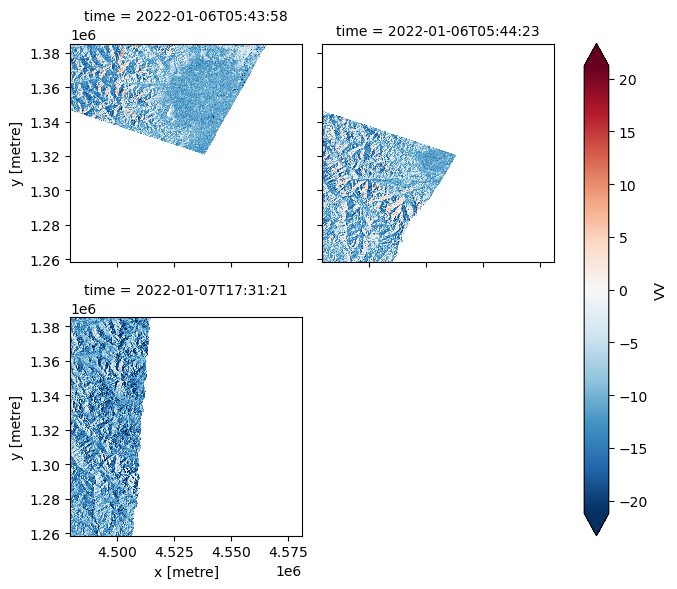

In [248]:
sig0_dc.VV.plot.imshow(col="time", col_wrap=2, robust=True)


In [249]:
# Transform to linear scale to do calculations 
sig0_dc_linear = 10 ** (sig0_dc / 10)                                

# Merge in time direction 

sig0_dc_linear_hourly = sig0_dc_linear.resample(time="1h").mean(dim="time") # time between e.g. 05:00:00 and 05:59:59.999 is averaged into the 05:00 bin

sig0_dc_linear_hourly = sig0_dc_linear_hourly.dropna(dim="time", how="all") # remove all empty bins

sig0_dc_linear_hourly

<xarray.Dataset> Size: 515MB
Dimensions:      (y: 6340, x: 5078, time: 2)
Coordinates:
  * y            (y) float64 51kB 1.385e+06 1.385e+06 ... 1.259e+06 1.259e+06
  * x            (x) float64 41kB 4.48e+06 4.48e+06 ... 4.581e+06 4.581e+06
  * time         (time) datetime64[ns] 16B 2022-01-06T05:00:00 2022-01-07T17:...
    spatial_ref  int32 4B 27704
Data variables:
    VH           (time, y, x) float32 258MB dask.array<chunksize=(1, 6340, 5078), meta=np.ndarray>
    VV           (time, y, x) float32 258MB dask.array<chunksize=(1, 6340, 5078), meta=np.ndarray>

In [250]:
# lower the resolution from 20m to 6km  (as 6.25km does not work because 312.5 is not an int())
sig0_dc_linear_6km = sig0_dc_linear_hourly.coarsen(x=300, y=300, boundary="pad").mean() # padded with NA

sig0_dc_linear_6km

<xarray.Dataset> Size: 6kB
Dimensions:      (time: 2, y: 22, x: 17)
Coordinates:
  * y            (y) float64 176B 1.382e+06 1.376e+06 ... 1.262e+06 1.259e+06
  * x            (x) float64 136B 4.483e+06 4.489e+06 ... 4.573e+06 4.578e+06
  * time         (time) datetime64[ns] 16B 2022-01-06T05:00:00 2022-01-07T17:...
    spatial_ref  int32 4B 27704
Data variables:
    VH           (time, y, x) float32 3kB dask.array<chunksize=(1, 21, 16), meta=np.ndarray>
    VV           (time, y, x) float32 3kB dask.array<chunksize=(1, 21, 16), meta=np.ndarray>

In [251]:
# ffill values 
sig_dc_linear_6km_filled = sig0_dc_linear_6km.ffill(dim="time")

sig_dc_linear_6km_filled

<xarray.Dataset> Size: 6kB
Dimensions:      (y: 22, x: 17, time: 2)
Coordinates:
  * y            (y) float64 176B 1.382e+06 1.376e+06 ... 1.262e+06 1.259e+06
  * x            (x) float64 136B 4.483e+06 4.489e+06 ... 4.573e+06 4.578e+06
  * time         (time) datetime64[ns] 16B 2022-01-06T05:00:00 2022-01-07T17:...
    spatial_ref  int32 4B 27704
Data variables:
    VH           (time, y, x) float32 3kB dask.array<chunksize=(1, 21, 16), meta=np.ndarray>
    VV           (time, y, x) float32 3kB dask.array<chunksize=(1, 21, 16), meta=np.ndarray>

In [252]:
# Convert back to dB
sig_dc_6km = 10 * np.log10(sig_dc_linear_6km_filled).compute()

In [257]:
# Show steps visually:
""" only run if in testing mode

sig0_dc_linear.VV.plot.imshow(col="time", col_wrap=3, robust=True)
plt.show()

sig0_dc_linear_hourly.VV.plot.imshow(col="time", col_wrap=2, robust=True)
plt.show()

sig0_dc_linear_6km.VV.plot.imshow(col="time", col_wrap=2, robust=True)
plt.show()

sig_dc_linear_6km_filled.VV.plot.imshow(col="time", col_wrap=2, robust=True)
plt.show()
#"""


' only run if in testing mode\n\nsig0_dc_linear.VV.plot.imshow(col="time", col_wrap=3, robust=True)\nplt.show()\n\nsig0_dc_linear_hourly.VV.plot.imshow(col="time", col_wrap=2, robust=True)\nplt.show()\n\nsig0_dc_linear_6km.VV.plot.imshow(col="time", col_wrap=2, robust=True)\nplt.show()\n\nsig_dc_linear_6km_filled.VV.plot.imshow(col="time", col_wrap=2, robust=True)\nplt.show()\n#'

In [256]:
sig_dc_6km.to_zarr("output_6km_filled.zarr", mode="w") # scaling?  ,encoding=

Equi 7 africa and europe test?

### Small testset

In [159]:
empty_data = items_eodc[0]

In [160]:
map = folium.Map(
    location=[(latmin + latmax) / 2, (lonmin + lonmax) / 2],
    zoom_start=7,
    zoom_control=False,
    scrollWheelZoom=False,
    dragging=False,
)

folium.Rectangle(
    bounds=[[latmin, lonmin], [latmax, lonmax]],
    color="blue",
    fill=True,
    fill_opacity=0.1,
    weight=2,
    popup="Area of Interest",
).add_to(map)

# url leading to display of an item, can also be used as hyperlink
image_url = empty_data.assets["thumbnail"].href
bounds = empty_data.bbox
folium.raster_layers.ImageOverlay(
    image=image_url,
    bounds=[[bounds[1], bounds[0]], [bounds[3], bounds[2]]],
).add_to(map)

folium.LayerControl().add_to(map)

map

In [ ]:
sig0_dc = odc_stac.load(
    [empty_data],
    crs=crs,
    resolution=res,
    bbox=bounding_box,
    chunks=chunks,
    resampling="bilinear",
)
sig0_dc

<xarray.Dataset> Size: 136MB
Dimensions:      (y: 6461, x: 5254, time: 1)
Coordinates:
  * y            (y) float64 52kB 1.444e+06 1.444e+06 ... 1.315e+06 1.315e+06
  * x            (x) float64 42kB 4.245e+06 4.245e+06 ... 4.35e+06 4.35e+06
    spatial_ref  int32 4B 27704
  * time         (time) datetime64[ns] 8B 2022-01-31T17:31:45
Data variables:
    VH           (time, y, x) int16 68MB dask.array<chunksize=(1, 6461, 5254), meta=np.ndarray>
    VV           (time, y, x) int16 68MB dask.array<chunksize=(1, 6461, 5254), meta=np.ndarray>

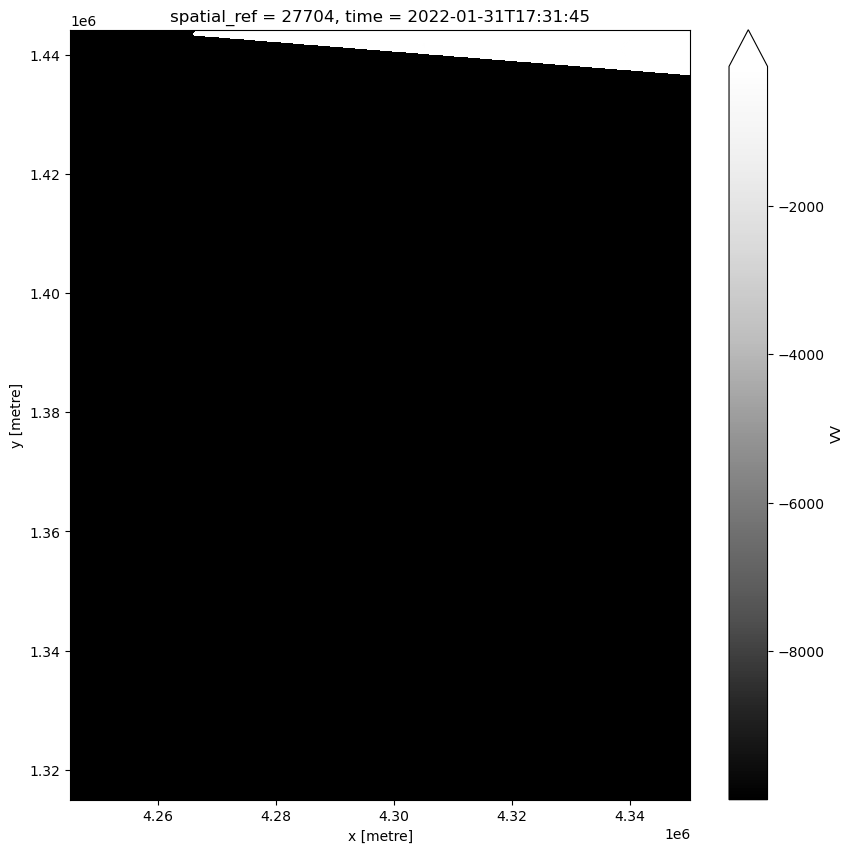

In [ ]:
sig0_dc = sig0_dc.where(sig0_dc != nodata) / scale
sig0_dc = sig0_dc.dropna(dim="time", how = "all")
sig0_dc.VV.plot(robust=True, cmap="Greys_r", aspect=1, size=10)

Learning:
- Check code from MRS repository
- Foliummap, thumbnail image and actual data are no not really algin at all

### Test reading error File:

In [ ]:
# Error when reading the file:

single_dc = odc_stac.load(
    [items_eodc[5]],
    #crs=crs,
    #resolution=res,
    #chunks={"time": 1, "latitude": 5, "longitude": 15000}  # Smaller chunks
)
        

single_dc
single_dc.compute()

Aborting load due to failure while reading: https://data.eodc.eu/collections/SENTINEL1_SIG0_20M/V1M1R1/EQUI7_EU020M/E048N012T3/SIG0_20221007T170631__VH_A117_E048N012T3_EU020M_V1M1R1_S1AIWGRDH_TUWIEN.tif:1


RasterioIOError: Read failed. See previous exception for details.

#### Draft:

In [ ]:
sig0_dc_linear = 10 ** (sig0_dc / 10)                                       

sig0_dc_linear_hourly = sig0_dc_linear.resample(time="1h").mean(dim="time")  # one hour is good
                                                                            
# --
sig_dc_linear_6p25 = sig0_dc_linear_hourly.coarsen(x=312.5, y=312.5).mean()  # from 20m to 6.25km 
                                                                             # here think of the gridpoints
                                                                             # should they start to align with the ASCAT data? it probably cant really align because grid system != point system

sig_dc_linear_6p25_filled = sig_dc_linear_6p25.ffill(dim = "time")

sig_dc_6p25 = 10 * np.log10(sig_dc_linear_6p25_filled)

sig_dc_6p25.to_zarr()






# later:
sig_dc_linear_6p25_fibgrid = 
sig_dc_linear_12p5_fibgrid = sig_dc_linear_6p25_fibgrid.nearest.neighbour

sig_dc_12p5_fibgrid = 10 * np.log10(sig_dc_linear_12p5_fibgrid)
sig_dc_12p5_fibgrid

Why is it ok to use the equi7 grid of europe?
- should be ok because the grid spanns a little bit into aftica and we only use a small piece in the north west of africa

### Test the resample
Documentation can be found under https://earth-env-data-science.github.io/lectures/xarray/xarray-part2.html.

In [ ]:
# testing the resampling for a smaller resolution:

crs = "EPSG:27704"  # Coordinate Reference System: EQUI7 Grid of Europe
res =  12500        # resampling to larger resulution should not be done for db data
nodata = items_eodc[0].assets["VV"].extra_fields["raster:bands"][0]["nodata"]
scale = items_eodc[0].assets["VV"].extra_fields["raster:bands"][0]["scale"]

chunks = {"time": 1, "latitude": 1000, "longitude": 1000}
sig0_dc_for_plotting = odc_stac.load(
    items_eodc,
    crs=crs,
    resolution=res, # bad practice as this is db data
    bbox=bounding_box,
    chunks=chunks,
    preprocess=lambda x: _preprocess(x, scale, nodata),
    resampling="bilinear",
)

sig0_dc_for_plotting

In [ ]:
sig0_dc_for_plotting = sig0_dc_for_plotting.isel(time=range(20)).compute()
sig0_dc_for_plotting

In [ ]:
sig0_dc_for_plotting.VV.plot.imshow(col="time", col_wrap=5)

In [ ]:
#sig0_dc.resample(x=625, y=625, time="1H").mean()   
sig0_dc_for_plotting_daily = sig0_dc_for_plotting.resample(time="1D").mean(dim='time')  # dont take the NAs into account
sig0_dc_for_plotting_daily
# lin2db(db2lin) should be used to create the correct mean but from where?

In [ ]:
sig0_dc_for_plotting_daily.VV.plot.imshow(col="time", col_wrap=5)

In [ ]:
sig0_dc.sel(time=slice("2021-01-01","2021-01-01T12:00:00")).VV.plot.imshow(col="time", col_wrap=5)

In [ ]:
sig0_dc.sel(time=slice("2021-01-01","2021-01-01T12:00:00")).isel(x=slice(0,5000), y=slice(0,5000)).VV.plot.imshow(col="time", col_wrap=5)

In [ ]:
lin2db(db2lin(sig0_dc).resample(x=500, y=500, time="1H").mean())

In [ ]:
item = items_eodc[-1]
scale = item.assets["VV"].extra_fields.get("raster:bands")[0]["scale"]
nodata = item.assets["VV"].extra_fields.get("raster:bands")[0]["nodata"]
sig0_dc = sig0_dc.where(sig0_dc != nodata) / scale

sig0_dc = sig0_dc.dropna(dim="time", how="all", subset=["VV"])  # .compute()
sig0_dc

In [ ]:
n = 20

ds_vv = (
    sig0_dc["VV"]
    .isel(x=slice(None, None, 10), y=slice(None, None, 10))
    .isel(time=slice(0, n))
)

ncols = 5
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))

axes = axes.flatten()

for i in range(n):
    vv_t = ds_vv.isel(time=i)
    ax = axes[i]
    im = vv_t.plot(ax=ax, robust=True, cmap="viridis", add_colorbar=False)
    ax.set_title(str(vv_t["time"].values)[:19])  # Shorten timestamp
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label="VV [dB]")

plt.suptitle("Sentinel-1 VV (Downsampled) - First 20 Time Steps", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


EODC has items that do not overlap and are about 25 seconds apart, as that is Sentinel-1 radar acquisition time.

In [ ]:
vv_t0 = sig0_dc.VV.isel(time=4)
vv_t1 = sig0_dc.VV.isel(time=5)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

vv_t0.plot(ax=axes[0], robust=True, cmap="viridis")
axes[0].set_title(f"Sentinel-1 VV - Time 0\n{str(vv_t0.time.values)}")

vv_t1.plot(ax=axes[1], robust=True, cmap="viridis")
axes[1].set_title(f"Sentinel-1 VV - Time 1\n{str(vv_t1.time.values)}")

plt.tight_layout()
plt.show()

So to avoid having double the amount of data per time instance, lets merge EODC items per hour. We can also merge per minute, or even day, since for this area we have data every ~4 days, so that is the rough temporal resolution. But let's keep it precision in the hourly range.

In [ ]:
# sig0_dc2 = sig0_dc.resample(time="d").first()

In [ ]:
hourly_time = sig0_dc.time.dt.floor("h")
sig0_dc = sig0_dc.assign_coords(hourly_time=("time", hourly_time.data))
sig0_dc = sig0_dc.groupby("hourly_time").mean(dim="time")
sig0_dc = sig0_dc.rename({"hourly_time": "time"})

sig0_dc

In [ ]:
n = 20

ds_vv = (
    sig0_dc["VV"]
    .isel(x=slice(None, None, 10), y=slice(None, None, 10))
    .isel(time=slice(0, n))
)

ncols = 5
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))

axes = axes.flatten()

for i in range(n):
    vv_t = ds_vv.isel(time=i)
    ax = axes[i]
    im = vv_t.plot(ax=ax, robust=True, cmap="viridis", add_colorbar=False)
    ax.set_title(str(vv_t["time"].values)[:19])  # Shorten timestamp
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")


fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label="VV [dB]")

plt.suptitle("Sentinel-1 VV (Downsampled) - First 20 Time Steps", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


We see that we have half of the time instances now. So let's plot first merged item (radar image) to see were images (that were acquired on the same day and in same hour) on the previous plot merged.

In [ ]:
sig0_dc.isel(time=0).VV.plot(size=8, robust=True)

Lets export the datacube as a zar file

In [ ]:
sig0_dc

In [ ]:
sig0_dc.to_zarr(r"C:\Users\jwagner\Desktop\ascat-sentinel-1-synergy\zarr-file.zarr")

In [ ]:
data_path = Path(r"C:\Users\jwagner\Desktop\ascat-sentinel-1-synergy\zarr-file.zarr").\
    expanduser()
fused_ds = xr.open_dataset(data_path, decode_coords="all", engine="zarr")

In [ ]:
fused_ds